In [1]:
import numpy as np
import scipy.io as sio
from scipy.stats import norm

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm

import pandas as pd

from sklearn.metrics import mean_squared_error

# for creating a responsive plot
%matplotlib inline

# Exercise 4 



In [2]:
# define variables
mu = np.ones((2,1))
s = np.array([[4,3],[3,5]])

In [3]:
# Define variances
s_xy = s[0,1]
s_y = np.sqrt((s[0,0]))
s_x = np.sqrt((s[1,1]))
s_xy, s_y, s_x

(3, 2.0, 2.23606797749979)

## 4.a Determine $E[y|x]$

Recalling that the optimal MSE estimate $E[y|x]$ is equal to $\mu_y + \dfrac{\alpha \sigma_y}{\sigma_x}(x-\mu_x)$, $\alpha = \dfrac{\sigma_{xy}}{\sigma_x \sigma_y}$.

* We will define a function to calculate $E[y|x]$ (for a given range of x) and then plot the result

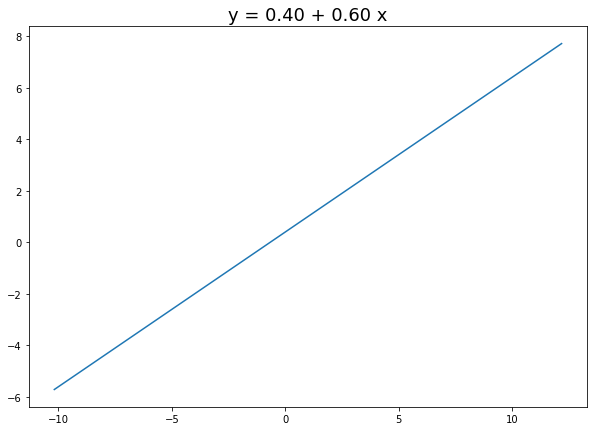

In [4]:
def MSE(x_range):

    # Calculate E[y|x]
    return c * x_range - c *mu[1] + mu[0]

# calculate alpha
a = s_xy/(s_x * s_y)

# coef
c = a * (s_y /(s_x))

# Plot E
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
x = np.linspace(mu[1] - 5*s_x, mu[1] + 5*s_x, 100)
ax.plot(x, MSE(x))
_ = ax.set_title(f"y = {(-c *mu[1] + mu[0])[0]:.2f} + {c:.2f} x", fontsize=18)

## 4.b Generate 100 data sets, each consisting of 50 pairs

In [5]:
def generate_data(mu,s, size):

    
    # Yield 50 X, y pairs
    y, X = np.random.multivariate_normal(mu.flatten(), s, size).T

    # define normal error
    n = np.random.normal(0,np.sqrt(0.01),len(X))

    # add noise to y
    y = y + n

    # return X and y
    return(np.concatenate((X.reshape(-1,1), y.reshape(-1,1), n.reshape(-1,1)), axis=1))

def yield_index(ds, num, size):
    """
    Function to return a virtual dataset from a np array with {size} data points per dataset
    Input:  an array containing all dataset, in order
            the requested dataset point (ex. in order to fetch dataset {size} num should be {size})
    Output: the range in which the specific dataset can be found
    """
    return ds[num*size-size: num*size]


In [6]:
size = 50
# Generate 100 datasets of size = 50
data = np.empty((1,3))
for i in range(100):
    data = np.concatenate((data, generate_data(mu, s, size)))
data = data[1:]

X_all = data[:,0]
y_all = data[:,1]
data[:5]

array([[ 1.23414441,  1.351992  ,  0.1282746 ],
       [-2.06646859,  1.50978976,  0.00432508],
       [ 2.94544033,  3.31383237,  0.13508284],
       [ 0.71112185, -1.44562892,  0.01566671],
       [ 1.39235447,  3.81783262, -0.00502644]])

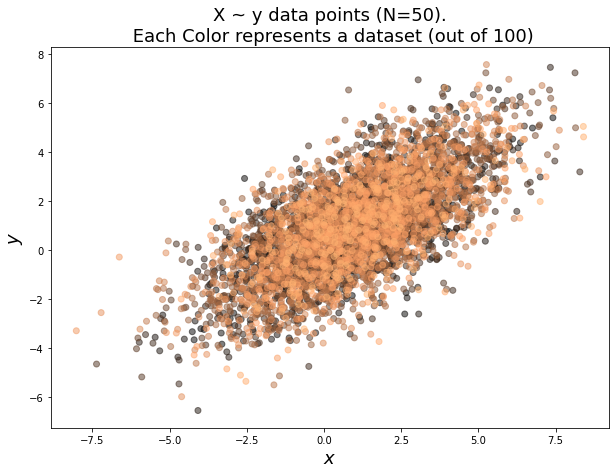

In [7]:
# Create 100 shades of color
colormap = plt.cm.copper #nipy_spectral, Set1,Paired  
colorst = [colormap(i) for i in np.linspace(0, 0.9,100)] 

#plot X data
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
for i in range(100):
    ax.scatter(yield_index(X_all, i+1, size),yield_index(y_all, i+1, size), c=[colorst[i]]*50,marker='o', alpha = 0.5)
ax.set_ylabel('$y$', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)
ax.set_title('X ~ y data points (Ν=50).\n Each Color represents a dataset (out of 100)', fontsize=18)
plt.show()

## 4.c Adopt a linear estimator and determine its instances utilizing the LS criterion

In [8]:
def perform_LS(X, y):
    """ Function to calculate the LS coeff. based on X (input) and y (output) tables"""
    # add ones to the transformed table for LS (since we have theta_0)
    X_new = np.append(np.ones((len(X),1)), X.reshape(-1,1), axis = 1)

    # Calculate the LS tables
    Xx_inv = np.linalg.inv(X_new.T.dot(X_new))
    Xy = X_new.T.dot(y)

    return Xx_inv.dot(Xy)

In [9]:
# Calculate \theta
theta = np.empty((1,2))
for i in range(100):
    # Fetch X and y for the given dataset number
    X = yield_index(X_all, i+1, size)
    y = yield_index(y_all, i+1, size)

    th = perform_LS(X, y)

    # Calculate and print coeff
    theta = np.concatenate((theta,th.reshape(1,2)))

theta = theta[1:]    
# theta = np.array(theta).reshape(-1,1)
theta.mean(axis=0)   

array([0.397218  , 0.59541279])

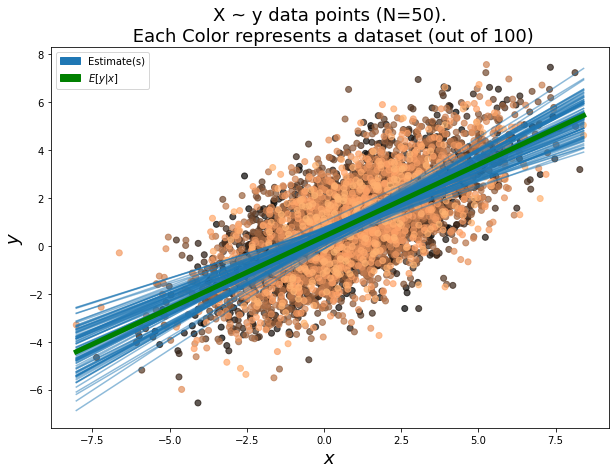

In [10]:
# Create patches for the legend
patches = [ mpatches.Patch(color = 'C0', label = 'Estimate(s)'), mpatches.Patch(color = 'green', label = '$E[y \\vert x]$') ]

# Define plot range
range_x = np.linspace(X_all.min(), X_all.max(), 100)

#plot X data
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
for i in range(100):
    ax.plot(range_x, theta[i][0] + theta[i][1] * range_x, c='C0',alpha = 0.5)
    ax.scatter(yield_index(X_all, i+1, size),yield_index(y_all, i+1, size), c=[colorst[i]]*50,marker='o', alpha = 0.7)
ax.plot(range_x, MSE(range_x), c='green',alpha = 1, lw=5)

# Labels and Title
ax.set_ylabel('$y$', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)
ax.set_title('X ~ y data points (Ν=50).\n Each Color represents a dataset (out of 100)', fontsize=18)

# Legend
_ = ax.legend(handles = patches, loc = 'upper left')

* Calculate the MSE

In [11]:
mse_pred = []
for i in range(100):
    mse_pred.append(mean_squared_error(MSE(yield_index(X_all, i+1, size)), theta[i][0] + theta[i][1] * yield_index(X_all, i+1, size)))
print(f"The MSE is {np.array(mse_pred).mean():.2e}")

The MSE is 8.48e-02


## 4.e Repeat steps (b)-(d) where now each data set consists of 𝑁=5000 points.

In [12]:
size = 5000

# Generate 100 datasets
data = np.empty((1,3))
for i in range(100):
    data = np.concatenate((data, generate_data(mu, s, size)))
data = data[1:]

X_all = data[:,0]
y_all = data[:,1]
data[:5]

array([[ 0.33027702, -0.30529462, -0.11819526],
       [ 3.61192219,  2.84690511,  0.0561533 ],
       [-3.1218365 , -0.45013544, -0.06299249],
       [ 4.06673899, -0.9115135 ,  0.01411599],
       [ 1.01267396,  2.25921837, -0.11222848]])

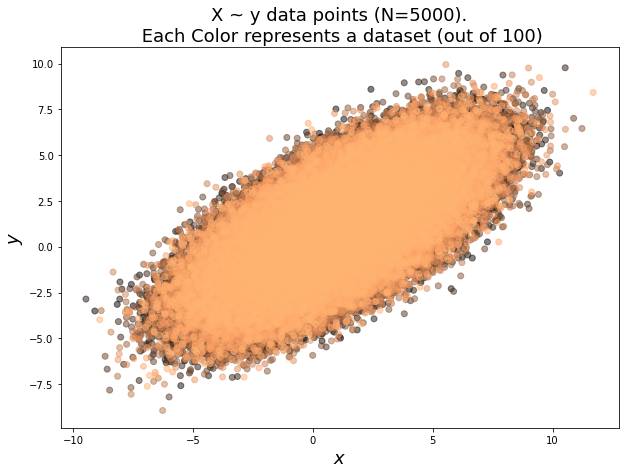

In [13]:
# Create 100 shades of color
colormap = plt.cm.copper #nipy_spectral, Set1,Paired  
colorst = [colormap(i) for i in np.linspace(0, 0.9,100)] 

#plot X data
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
for i in range(100):
    ax.scatter(yield_index(X_all, i+1, size),yield_index(y_all, i+1, size), c=[colorst[i]]*size,marker='o', alpha = 0.5)
ax.set_ylabel('$y$', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)
ax.set_title('X ~ y data points (Ν=5000).\n Each Color represents a dataset (out of 100)', fontsize=18)
plt.show()

In [14]:
# Calculate \theta
theta = np.empty((1,2))
for i in range(100):
    # Fetch X and y for the given dataset number
    X = yield_index(X_all, i+1, size)
    y = yield_index(y_all, i+1, size)

    th = perform_LS(X, y)

    # Calculate and print coeff
    theta = np.concatenate((theta,th.reshape(1,2)))

theta = theta[1:]    
theta.mean(axis=0)  

array([0.3976096 , 0.59959555])

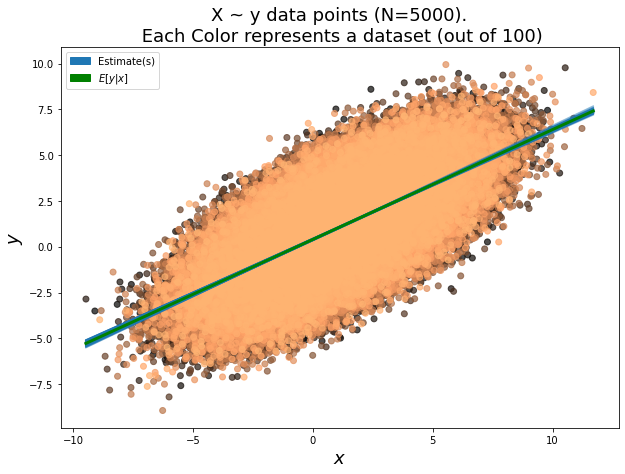

In [15]:
# Define plot range
range_x = np.linspace(X_all.min(), X_all.max(), 100)

#plot X data
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
for i in range(100):
    ax.plot(range_x, theta[i][0] + theta[i][1] * range_x, c='C0',alpha = 0.5)
    ax.scatter(yield_index(X_all, i+1, size),yield_index(y_all, i+1, size), c=[colorst[i]]*size,marker='o', alpha = 0.7)
ax.plot(range_x, MSE(range_x), c='green',alpha = 1, lw=3)
ax.set_ylabel('$y$', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)
ax.set_title('X ~ y data points (Ν=5000).\n Each Color represents a dataset (out of 100)', fontsize=18)
_ = ax.legend(handles = patches, loc = 'upper left')

* Calculate the MSE

In [16]:
mse_pred = []
for i in range(100):
    mse_pred.append(mean_squared_error(MSE(yield_index(X_all, i+1, size)), theta[i][0] + theta[i][1] * yield_index(X_all, i+1, size)))
print(f"The MSE is {np.array(mse_pred).mean():.2e}")

The MSE is 8.21e-04


## 4.f Discuss the results (in your discussion, take into account the decomposition of the MSE to a variance and a bias term).

The optimal MSE can be writen as:
$E_D[(f(x;D) - E[y \vert x])^2] = E_D[(f(x;D) - E_D[(f(x;D)])^2] + (E_D[f(x;D)] - E[y \vert x])^2$

We can explain the two terms as follows:<br>
* Variance Term: Variance of the estimator around its mean value<br>
* Bias $^2$ Term: Difference of the mean from optimal estimate<br>

In this excercise we demonstrared how the increase in the number of samples reduces the MSE. As we know for a fixed number of points N in all data sets D, it is not possible to reduce both terms simultaneously. Thus, by increasing the number of samples we achieved two things.
First, the Bias term (which is the difference of the mean from the optimal estimate) deacreased, since with more points each estimation will be closer to the optimal estimate and, second, the variance of each estimator is closer to the mean value. That way we managed to decrease the MSE, decreasing both the variance and the Bias term. 

Those observations can be better understood in the two corresponding graphs, showing the points along with the lines.

# Exercise 5

## 5.a Generate a single data set $D$ of 100 pairs.

In [17]:
# Generate 100 pairs
data = np.empty((1,3))
data = np.concatenate((data, generate_data(mu, s, 100)))
data = data[1:]

X_100 = data[:,0]
y_100 = data[:,1]
data[:5]

array([[-1.00112094,  0.37927004,  0.16288617],
       [ 0.73981416,  0.7603593 , -0.019704  ],
       [ 0.69742994,  0.05251665, -0.02519947],
       [ 2.16703095,  1.86330461,  0.07017491],
       [ 1.05166821, -0.23755013,  0.03182355]])

## 5.b Determine the linear estimate that minimizes the MSE criterion based on $D$.

In [18]:
# Calculate and print coeff
theta_100 = perform_LS(X_100,y_100)

print(f"y = {theta_100[0]:.2f} + {theta_100[1]:.2f} x")

y = 0.03 + 0.66 x


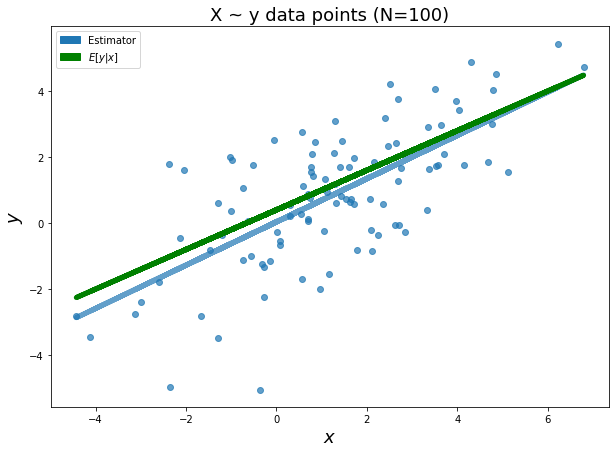

In [19]:
# Create patches for the legend
patches = [ mpatches.Patch(color = 'C0', label = 'Estimator'), mpatches.Patch(color = 'green', label = '$E[y \\vert x]$') ]

#plot X data
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.plot(X_100, theta_100[0] + theta_100[1] * X_100, c='C0',alpha = 0.7, lw=5)
ax.scatter(X_100,y_100, marker='o', alpha = 0.7)
ax.plot(X_100, MSE(X_100), c='green',alpha = 1, lw=5)
ax.set_ylabel('$y$', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)
ax.set_title('X ~ y data points (Ν=100)', fontsize=18)

_ = ax.legend(handles = patches, loc = 'upper left')

## 5.c Generate randomly a set $D'$ of additional 50 points and determine the estimate

In [20]:
# Generate 50 pairs
data = np.empty((1,3))
data = np.concatenate((data, generate_data(mu, s, 50)))
data = data[1:]

X_50 = data[:,0]
y_50 = data[:,1]
data[:5]

# Print coeff
print(f"y = {theta_100[0]:.2f} + {theta_100[1]:.2f} x")

y = 0.03 + 0.66 x


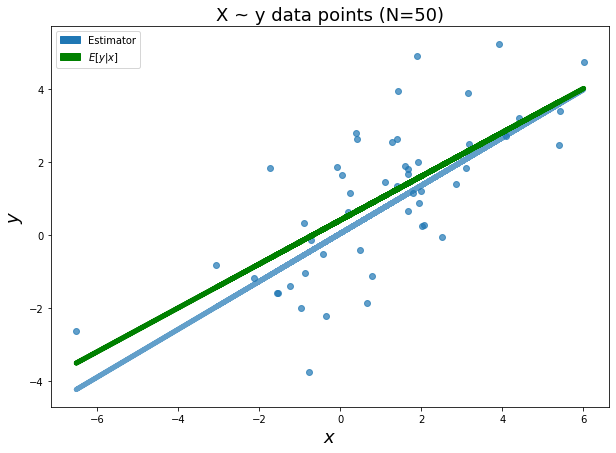

In [21]:
#plot X data
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.plot(X_50, theta_100[0] + theta_100[1] * X_50, c='C0',alpha = 0.7, lw=5)
ax.scatter(X_50,y_50, marker='o', alpha = 0.7)
ax.plot(X_50, MSE(X_50), c='green',alpha = 1, lw=5)
ax.set_ylabel('$y$', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)
ax.set_title('X ~ y data points (Ν=50)', fontsize=18)

_ = ax.legend(handles = patches, loc = 'upper left')

## 5.d Determine the associated estimates based on the optimal estimator

In [22]:
# determine estimates based on linear estimate
y_hat = theta_100[0] + theta_100[1] * X_50

# determine estimates based on optimal estimate
y_bar = MSE(X_50)

print(f"MSE for the Linear estimates:\t {mean_squared_error(y_50,y_hat):.2f}\n\
MSE for the optimal estimates:\t {mean_squared_error(y_50,y_bar):.2f}")

MSE for the Linear estimates:	 2.15
MSE for the optimal estimates:	 2.07


## 5.e Based on the previous derived estimates for the 50 points, propose and use a (practical) way for quantifying the performance of the two estimators.

As shown in the results of 5.d, we can see that one wasy of quantifying the performance of the two estimators is to use the Mean Squared Error on the estimates vs the actual values. As we can see in this example, the Linear estimates derived a higher MSE compared to the optimal one. Other metrics that could potentially be used are the MAE, RMSE and more. 

# Exercise 6

Generate a set $D$ of $N=100$ data pairs.

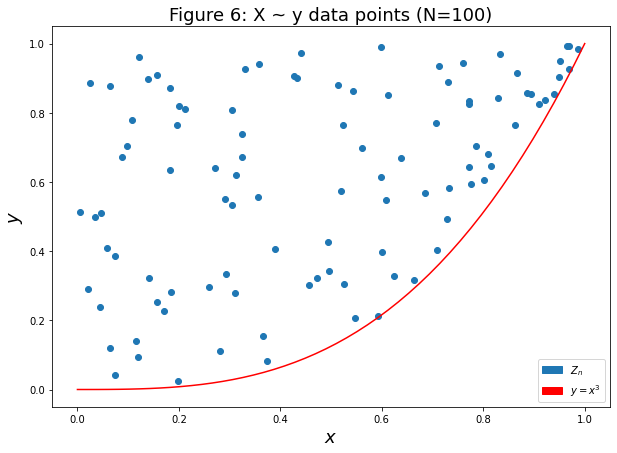

In [23]:
np.random.seed(42)
# Define Z
X = np.random.random(100)
y = []
for i in X:
    y.append(np.random.uniform(i**3,1))
y = np.array(y)

# Create patches for the legend
patches = [ mpatches.Patch(color = 'C0', label = '$Z_n$'), mpatches.Patch(color = 'red', label = '$y = x^3$') ]

#plot X data
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

# Define Range
plot_range = np.linspace(0,1,50)

ax.scatter(X, y, c='C0')
ax.plot(plot_range, np.power(plot_range,3), c='r')
ax.set_ylabel('$y$', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)
ax.set_title('Figure 6: X ~ y data points (Ν=100)', fontsize=18)

_ = ax.legend(handles = patches, loc = 'lower right')

In [24]:
# Define z
z = np.concatenate((X.reshape(-1,1), y.reshape(-1,1)), axis=1)


## 6.a For each $x_n$ compute the optimal MSE estimate

We recall (from ex. 3) that: $E[y \vert x] = \dfrac{1-x^6}{2( 1 - x^3)}$.

In [25]:
# Calculate the optimal MSE for each x.
E_xy = (1 - np.power(X, 6))/ (2 * (1 - np.power(X, 3)))

# calculate the optimal MSE of X
mean_squared_error(y, E_xy)

0.05916528520380385

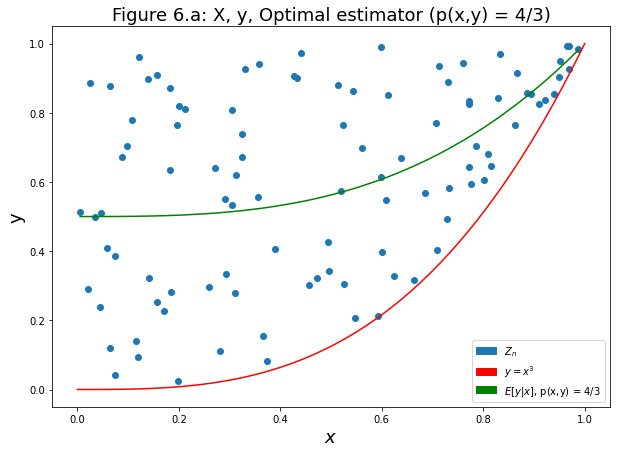

In [26]:
# sort tables to print
x_o = X.copy()
x_o.sort()
E_xy.sort()

# add legend 
patches.append(mpatches.Patch(color = 'g', label = '$E[y \\vert x]$, p(x,y) = 4/3'))

#plot X data
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

ax.plot(x_o, E_xy, c='g')

ax.scatter(X, y, c='C0')
ax.plot(plot_range, np.power(plot_range,3), c='r')

ax.set_ylabel('y', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)
ax.set_title('Figure 6.a: X, y, Optimal estimator (p(x,y) = 4/3)', fontsize=18)

_ = ax.legend(handles = patches, loc = 'lower right')

## 6.b Compute $\mu$ and $\Sigma$

In [27]:
# Calculate mu
mu = np.array([[X.mean()],[y.mean()]])
print('mean',mu)

# Calculate s
s = np.zeros((2,2))
for i in range(len(z)):
    s += ((mu - z[i].reshape(-1,1)).dot((mu - z[i].reshape(-1,1)).T))
s = s/len(z)
print('var',s)

mean [[0.47018074]
 [0.61565022]]
var [[0.08761495 0.03522882]
 [0.03522882 0.07619404]]


## 6.c 

Pretend that you do not know the true distribution that generates the data and you (erroneously) assume that the joint pdf of x and y is a normal one with mean and covariance matrix those computed in (b). Derive the optimum MSE estimate for this case and compute the MSE estimate for each one of the 100 $x_n$‘s.

In [28]:
# Define variances
s_xy = s[0,1]
s_y = np.sqrt((s[0,0]))
s_x = np.sqrt((s[1,1]))

def MSE(x_range):

    # Calculate E[y|x]
    return c * x_range - c *mu[0] + mu[1]

# calculate alpha
a = s_xy/(s_x * s_y)

# coef
c = a * (s_y /(s_x))

# calculate the optimal MSE of X
mean_squared_error(y, MSE(X))

0.06234724804068661

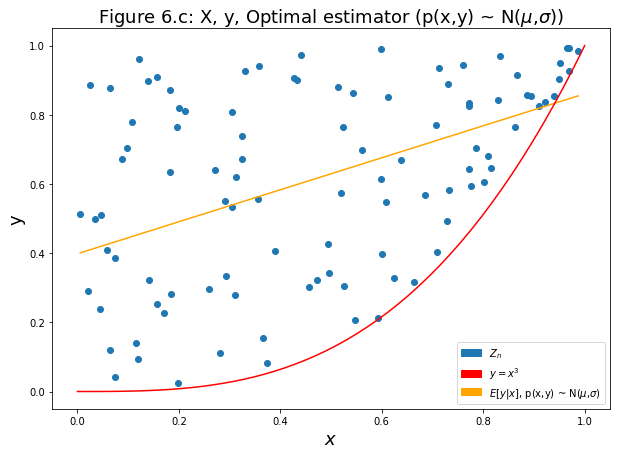

In [29]:
result = MSE(x_o).copy()
result.sort

# add legend 
patches.append(mpatches.Patch(color = 'orange', label = '$E[y \\vert x]$, p(x,y) ~ N($\mu$,$\sigma$)'))

#plot X data
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

ax.plot(x_o, result, c='orange')

ax.scatter(X, y, c='C0')
ax.plot(plot_range, np.power(plot_range,3), c='r')

ax.set_ylabel('y', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)
ax.set_title('Figure 6.c: X, y, Optimal estimator (p(x,y) ~ N($\mu$,$\sigma$))', fontsize=18)

_ = ax.legend(handles = patches[:2] + [patches[-1]], loc = 'lower right')

## 6.d Discuss the results obtained from (a) and (c).

In this excersice we approached the problem in two ways. Initially we used the optimal MSE, which is derived using the joint pdf, and presented in the previous exercise (3). That way our estimates follow the curve shown in FIgure 6.a.
Following this approach, after calculating the mean and variance for both inputs (X,y) we considered that the random variables follow a normal distribution and derived the Optimal (linear) estimate, which can be found in Figure 6.c.

In order to evaluate the results we calculated the MSE of both cases comparing the actual vs the predicted values. We received the following results:

|Method|MSE|
|---|---|
|p(x,y) = 4/3|5.92e-2|
|p(x,y) ~ N($\mu$,$\sigma$)|6.230e-2|

As we see the results are close, but what does this mean?

Looking at both graphs we can see that the data doesn't follow a clear "trend" inside the domain, $x \in [0,1), y \in (x^3,1)$, apart from a general upwards trend, thus. Since both MSEs follow that trend, either using a straight line or a slight curve we expect to get more of less the same results. As we can see the optimal MSE explains the data is a better way, and we expect to have better results. 

Finally it is worth noting that the number of samples is relatively low, thus a clearer picture could be obtained if we had an increased number of samples, but the conclusions would be the same

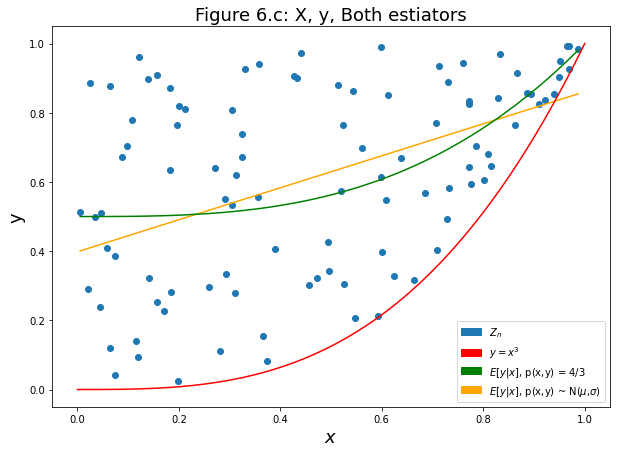

In [30]:
#plot X data
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

ax.plot(x_o, result, c='orange')
ax.plot(x_o, E_xy, c='g')

ax.scatter(X, y, c='C0')
ax.plot(plot_range, np.power(plot_range,3), c='r')

ax.set_ylabel('y', fontsize=18)
ax.set_xlabel('$x$', fontsize=18)
ax.set_title('Figure 6.c: X, y, Both estiators', fontsize=18)

_ = ax.legend(handles = patches, loc = 'lower right')